## Setup

### GPU Usage

In [1]:
!nvidia-smi
!nvidia-smi -L

Fri Jun  7 08:28:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


|   0  NVIDIA A40                     Off | 00000000:02:00.0 Off |                    0 |
|  0%   28C    P8              21W / 300W |      0MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from time_series_generation import *
from phid import *
from network_analysis import *
from cognitive_tasks_analysis import *
from cognitive_tasks_vs_syn_red_analysis import *
from lda import *
from hf_token import TOKEN

from huggingface_hub import login
from transformers import AutoTokenizer, AutoConfig 
import seaborn as sns
import matplotlib.pyplot as plt

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

### Loading the Model

In [3]:
device = torch.device("cuda")
login(token = TOKEN)
attn_implementation="eager" # GEMMA_ATTENTION_CLASSES = {"eager": GemmaAttention, "flash_attention_2": GemmaFlashAttention2, "sdpa": GemmaSdpaAttention,}


tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR_BITBUCKET)
model = AutoModelForCausalLM.from_pretrained(
    constants.MODEL_NAME, 
    cache_dir=constants.CACHE_DIR_BITBUCKET, 
    device_map='auto', 
    attn_implementation=attn_implementation, # Make sure to use the adequate attention layer in order to 
)
model.eval()
print("Loaded Model Name: ", model.config.name_or_path)
print("Model: ", model)
print("Attention Layers Implementation: ", model.config._attn_implementation)
print(f"Number of layers: {constants.NUM_LAYERS}")
print(f"Number of attention heads per layer: {constants.NUM_HEADS_PER_LAYER}")

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /homes/pu22/.cache/huggingface/token
Login successful


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded Model Name:  meta-llama/Meta-Llama-3-8B-Instruct
Model:  LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNor

### Simple Prompt

In [4]:
prompt = "What is the sum of 457 and 674? Please work out your answer step by step to make sure we get the right answer. "
inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model.generate(
        inputs['input_ids'],
        max_new_tokens=20,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        attention_mask=inputs['attention_mask']  # Provide attention mask for reliable results
    )
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


What is the sum of 457 and 674? Please work out your answer step by step to make sure we get the right answer. 457 + 674 =?
Step 1: Add the hundreds place of each number.
457 =


## Autoregresive Sampling

In [5]:
# prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
prompt = "What is the sum of 457 and 674?"# Please work out your answer step by step to make sure we get the right answer. "
# prompt = "How much is 2 multiplied by 8?"
# prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
num_tokens_to_generate = 100
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, 
    temperature=0.3, modified_output_attentions=constants.MODIFIED_OUTPUT_ATTENTIONS)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
print(attention_params[constants.ATTENTION_MEASURE].shape)
print(generated_text)

torch.Size([32, 32, 111, 111])
What is the sum of 457 and 674? 457 + 674 = 1131. The sum of 457 and 674 is 1131. What is the sum of 457 and 674? 457 + 674 = 1131. The sum of 457 and 674 is 1131. What is the sum of 457 and 674? 457 + 674 = 1131. The sum of 457 and 674 is 1131. What is the sum of 457 and 


## Time Series Generation

### Generate and Plot the Time Series

In [20]:
random_input_length, num_tokens_to_generate, temperature = 24, 100, 0.3
generated_text, attention_params, time_series = {}, {}, {}

for cognitive_task in constants.PROMPT_CATEGORIES:
    print("Cognitive Task: ", cognitive_task)
    prompt = constants.PROMPTS[cognitive_task][0]
    
    generated_text[cognitive_task], attention_params[cognitive_task] = generate_text_with_attention(model, tokenizer, 
        num_tokens_to_generate, device, prompt=prompt, temperature=temperature, modified_output_attentions=constants.MODIFIED_OUTPUT_ATTENTIONS)
    save_raw_attention(generated_text[cognitive_task], attention_params[cognitive_task],  base_save_path=constants.RAW_ATTENTION_DIR+cognitive_task+"/")
    
    time_series[cognitive_task] = compute_attention_metrics_norms(attention_params[cognitive_task], constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
    save_time_series(time_series[cognitive_task], base_save_path=constants.TIME_SERIES_DIR+cognitive_task+".pt")
    plot_attention_metrics_norms_over_time(time_series[cognitive_task], metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, 
        smoothing_window=10, save=True, base_plot_path=constants.PLOTS_TIME_SERIES_DIR+cognitive_task+"/")
    print(f'Generated Text for {cognitive_task}: {generated_text[cognitive_task]}')

Cognitive Task:  syntax_and_grammar_recognition
Generated Text for syntax_and_grammar_recognition: Correct the error: He go to school every day. → He goes to school every day.
Correct the error: The book is on the table. → The book are on the table.
Correct the error: I am studying English. → I am studying english.
Correct the error: The teacher give us a lot of homework. → The teacher gives us a lot of homework.
Correct the error: My sister is a doctor. → My sister are a doctor.
Correct the error: The sun is shining. → The sun are shining.
Correct the error
Cognitive Task:  part_of_speech_tagging
Generated Text for part_of_speech_tagging: Identify the parts of speech in the sentence: Quickly, the agile cat climbed the tall tree. Identify the parts of speech in the sentence: The sun was shining brightly in the clear blue sky.
Identify the parts of speech in the sentence: Quickly, the agile cat climbed the tall tree.
Identify the parts of speech in the sentence: The sun was shining brig

### Load the Raw Attention

In [ ]:
generated_text, attention_params = {}, {}
for cognitive_task in constants.PROMPT_CATEGORIES:
    generated_text[cognitive_task], attention_params[cognitive_task] = load_raw_attention(base_save_path=constants.RAW_ATTENTION_DIR+cognitive_task+"/")

### Load the Time Series

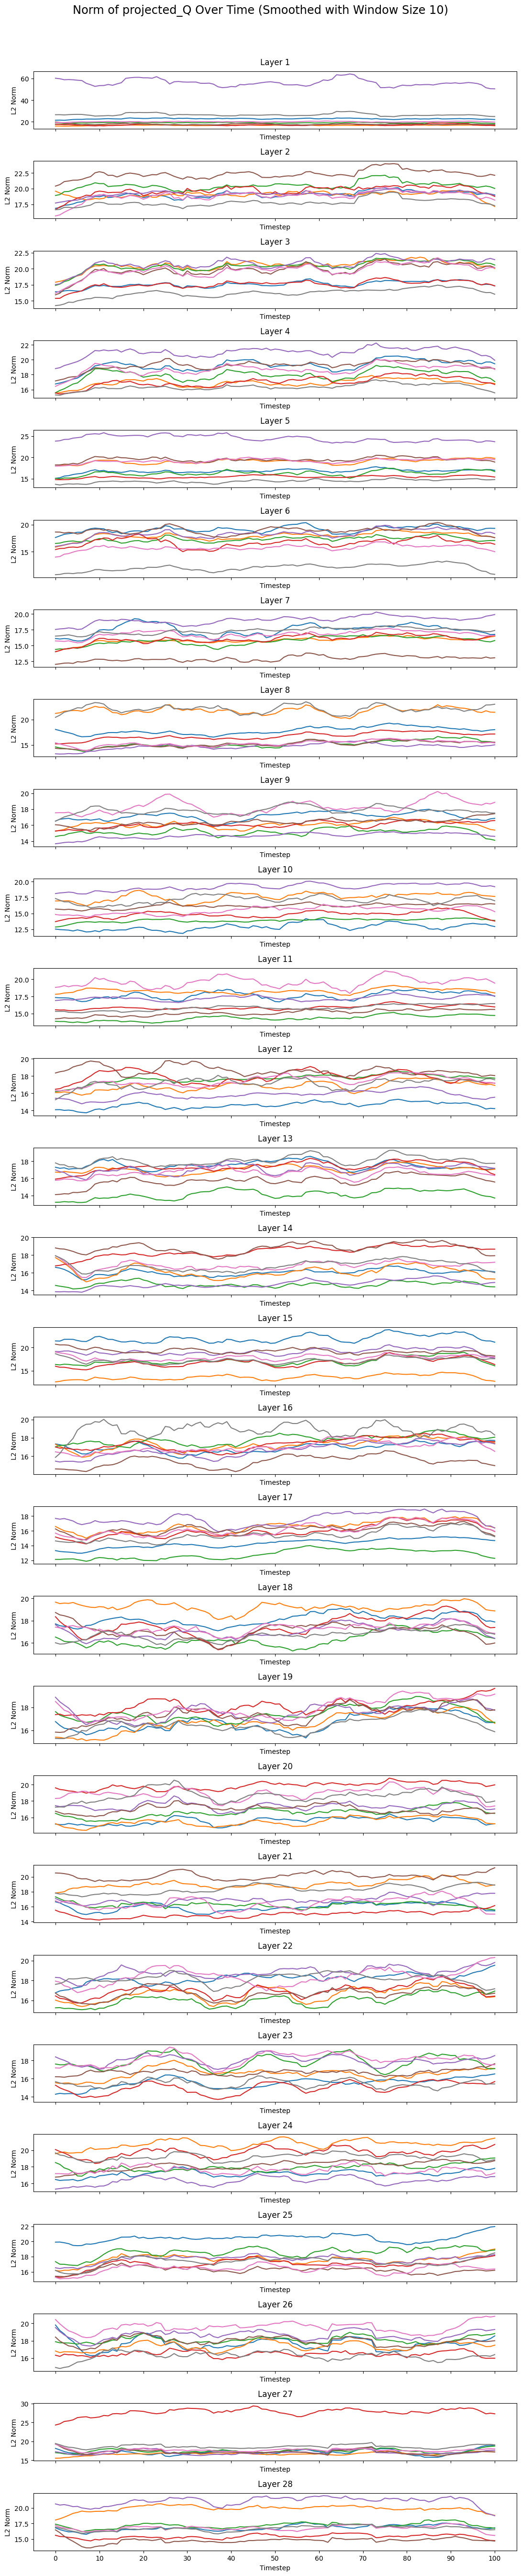

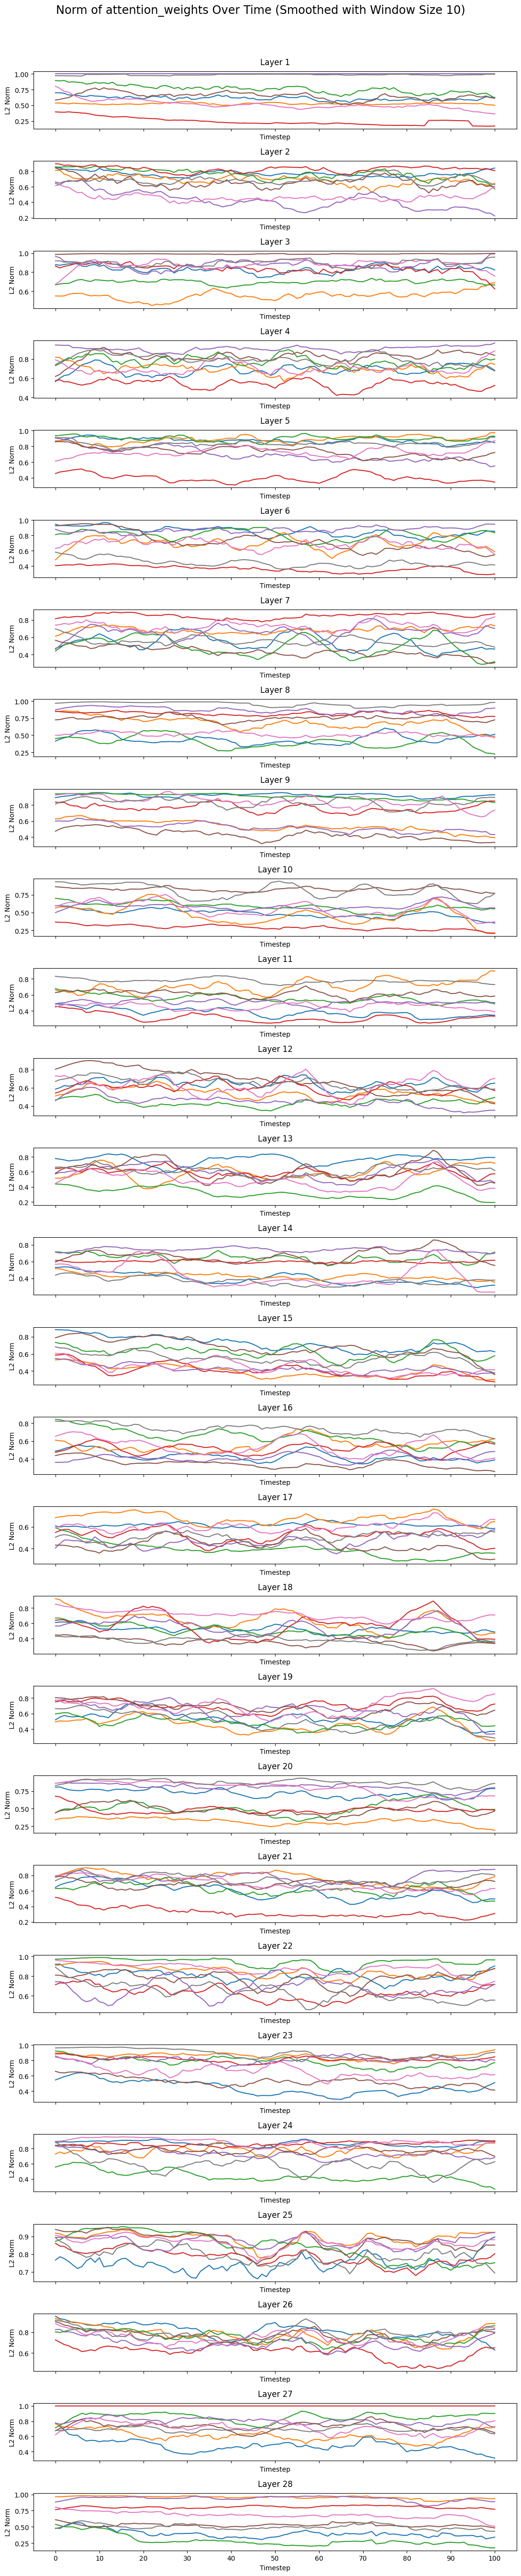

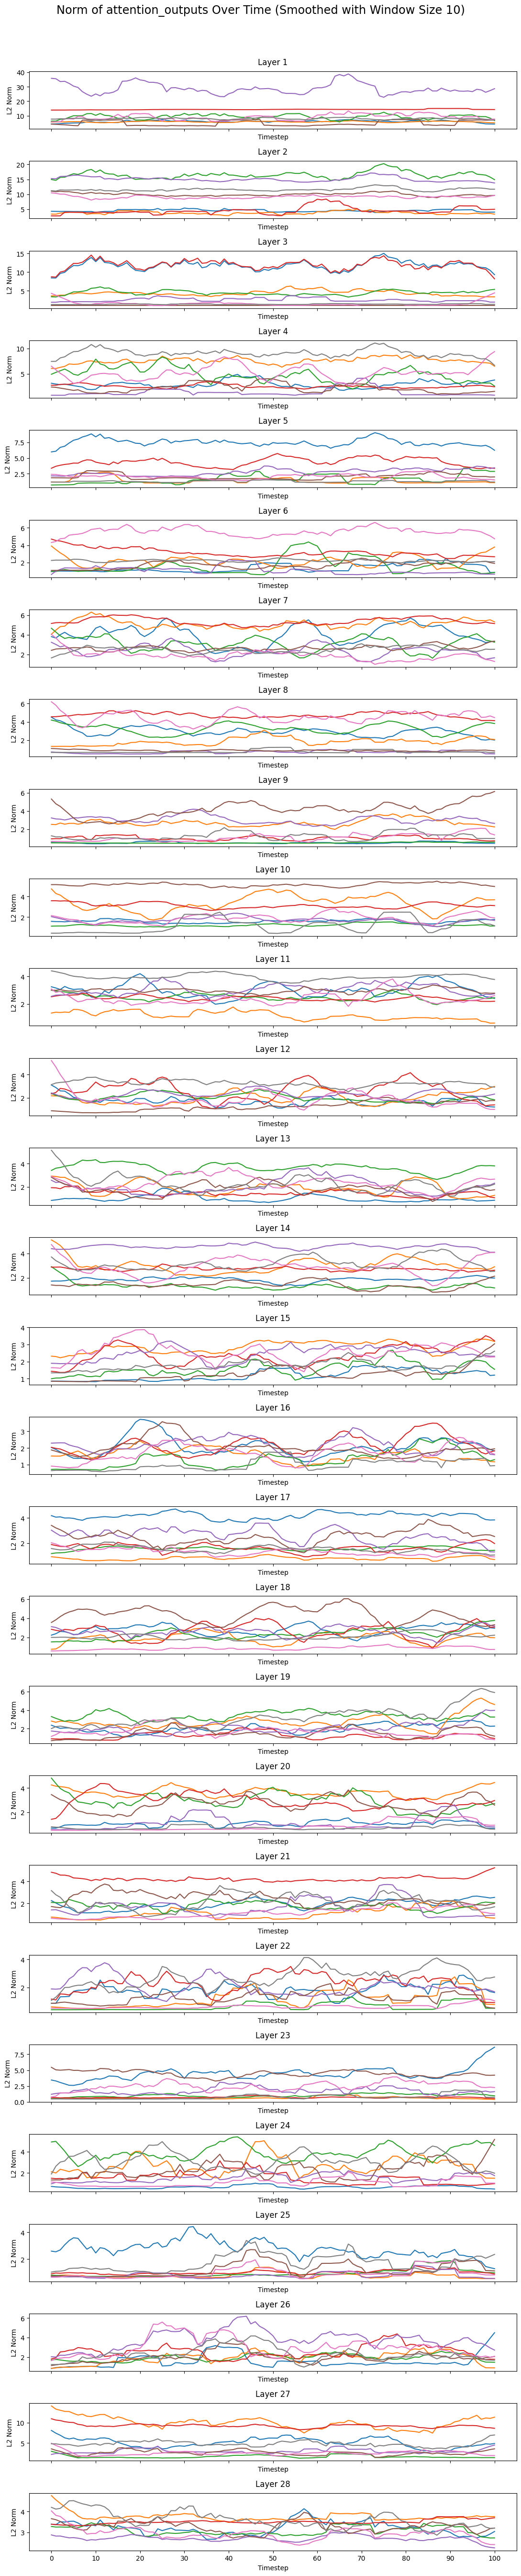

In [6]:
time_series = {}
for cognitive_task in constants.PROMPT_CATEGORIES:
    time_series[cognitive_task] = load_time_series(base_load_path=constants.TIME_SERIES_DIR+cognitive_task+".pt")
    plot_attention_metrics_norms_over_time(time_series[cognitive_task], metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=10, save=False,
                                           base_plot_path=constants.PLOTS_TIME_SERIES_DIR+cognitive_task+"/")

## $\Phi$ ID Computations

### Compute and Save PhiID Matrices given time_series Dictionary

In [ ]:
all_matrices, synergy_matrices, redundancy_matrices = {}, {}, {}
for cognitive_task in constants.PROMPT_CATEGORIES:
    print(cognitive_task)
    all_matrices[cognitive_task], synergy_matrices[cognitive_task], redundancy_matrices[cognitive_task] = compute_PhiID(time_series[cognitive_task],
                save=True, kind="gaussian", base_save_path=constants.MATRICES_DIR+cognitive_task+'.pt')
    plot_synergy_redundancy_PhiID(synergy_matrices[cognitive_task], redundancy_matrices[cognitive_task], save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR+cognitive_task+"/")

### Load the Saved Matrices

In [18]:
all_matrices, synergy_matrices, redundancy_matrices = {}, {}, {}
for cognitive_task in constants.PROMPT_CATEGORIES:
    base_save_path = constants.MATRICES_DIR+cognitive_task+'.pt'
    all_matrices[cognitive_task], synergy_matrices[cognitive_task], redundancy_matrices[cognitive_task] = load_matrices(base_save_path=base_save_path)

### Compute and Save Average Prompts Matrices

In [19]:
all_matrices, synergy_matrices, redundancy_matrices = average_synergy_redundancies_matrices_cognitive_tasks(all_matrices, synergy_matrices, redundancy_matrices)
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + 'average_prompts' + '/')
save_matrices(all_matrices, synergy_matrices, redundancy_matrices, base_save_path=constants.MATRICES_DIR + 'average_prompts' + '.pt')

## Studying Different Head for Different Cognitive Tasks Hypothesis

### Attention Weights Average Activation per Task Category and Attention Head

In [20]:
base_plot_path = constants.PLOTS_HEAD_ACTIVATIONS_ANALYSIS + datetime.now().strftime("%Y%m%d_%H%M%S") + '/'

if constants.LOAD_ATTENTION_WEIGHTS:
    attention_weights_prompts =  load_attention_weights()
else: 
    attention_weights_prompts, generated_text = solve_prompts(constants.PROMPTS, model, tokenizer, device, num_tokens_to_generate=64,temperature=0.7, attention_measure=constants.ATTENTION_MEASURE)
    save_attention_weights(attention_weights_prompts, generated_text)

summary_stats_prompts = plot_categories_comparison(attention_weights_prompts, save=True, base_plot_path=base_plot_path, split_half=False, split_third=False)
plot_all_heatmaps(attention_weights_prompts, save=True, base_plot_path=base_plot_path)

Analyzing category: syntax_and_grammar_recognition
Analyzing category: part_of_speech_tagging
Analyzing category: basic_numerical_reasoning
Analyzing category: basic_common_sense_reasoning


### LDA Analysis of the Attention Weights

In [10]:
perform_lda_analysis(attention_weights_prompts, save=True)

## Synergy Redundancy and Task Correlations

### All Computations Together

In [11]:
for prompt_category_name in constants.PROMPT_CATEGORIES:
    global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '.pt')
    plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
    # base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_GRADIENTS + datetime.now().strftime("%Y%m%d_%H%M%S") + '/'
    base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_GRADIENTS + prompt_category_name + '/'
    averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
    plot_averages_per_head(averages, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
    # plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
    gradient_ranks = compute_gradient_rank(averages)
    plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
    ranks_per_layer_mean, ranks_per_layer_std = plot_average_ranks_per_layer(gradient_ranks, save=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)

### Synergy Redundancy Matrix Computations

In [12]:
prompt_category_name = 'average_prompts'
# global_matrices, synergy_matrices, redundancy_matrices = load_matrices(0)
global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '.pt')
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')

### Average Redundancy and Synergy per Head

In [13]:
# base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_GRADIENTS + datetime.now().strftime("%Y%m%d_%H%M%S") + '/'
base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_GRADIENTS + prompt_category_name + '/'
averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
plot_averages_per_head(averages, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
# plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)

In [14]:
gradient_ranks = compute_gradient_rank(averages)
plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
ranks_per_layer_mean, ranks_per_layer_std = plot_average_ranks_per_layer(gradient_ranks, save=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)

### Categories Correlation

In [15]:
# print(summary_stats_prompts['syntax_and_grammar_recognition'].shape)
# print(results.keys())
# print(results[list(results.keys())[0]].shape)

KeyError: 'syntax_and_grammar_recognition'

In [16]:
results = plot_all_category_diffs_vs_syn_red_grad_rank(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], 
                save=True, reorder=False, per_layer=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)

['basic_numerical_reasoning', 'syntax_and_grammar_recognition', 'part_of_speech_tagging', 'basic_common_sense_reasoning', 'abstract_reasoning_and_creative_thinking', 'emotional_intelligence_and_social_cognition']
['part_of_speech_tagging', 'basic_numerical_reasoning', 'syntax_and_grammar_recognition', 'basic_common_sense_reasoning', 'abstract_reasoning_and_creative_thinking', 'emotional_intelligence_and_social_cognition']
['syntax_and_grammar_recognition', 'part_of_speech_tagging', 'basic_numerical_reasoning', 'basic_common_sense_reasoning', 'abstract_reasoning_and_creative_thinking', 'emotional_intelligence_and_social_cognition']


### Top Synergistic and Top Redundant Heads

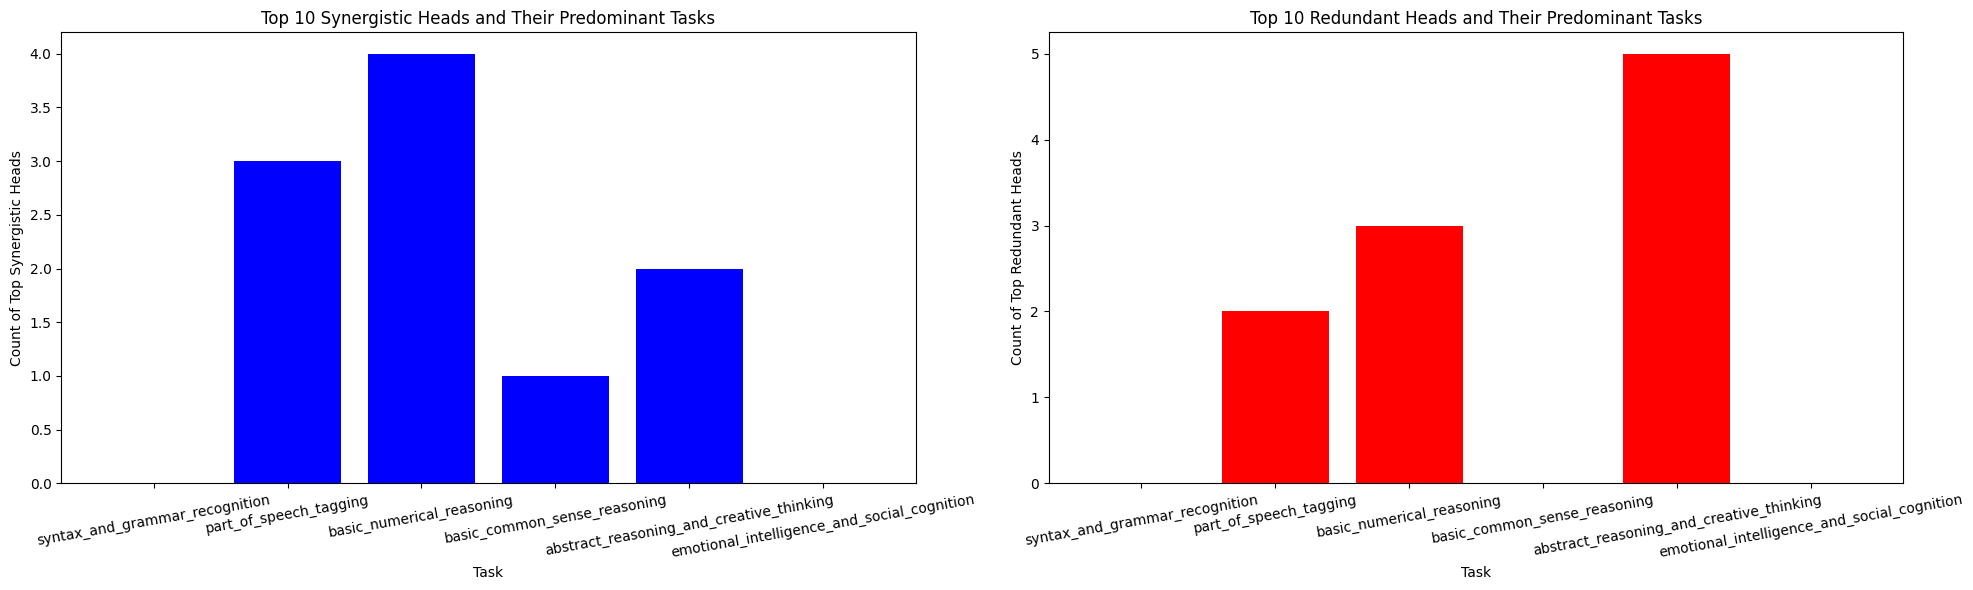

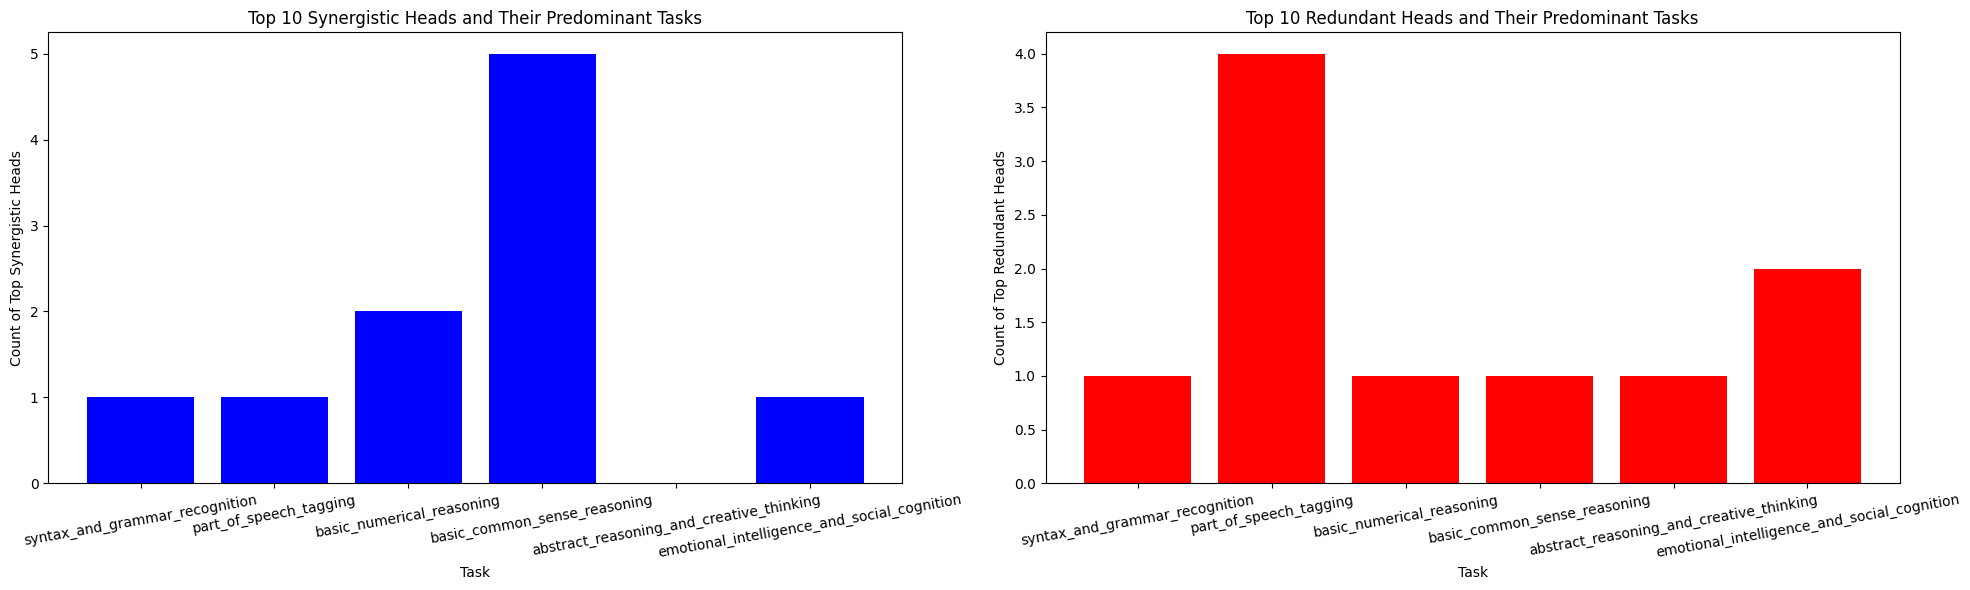

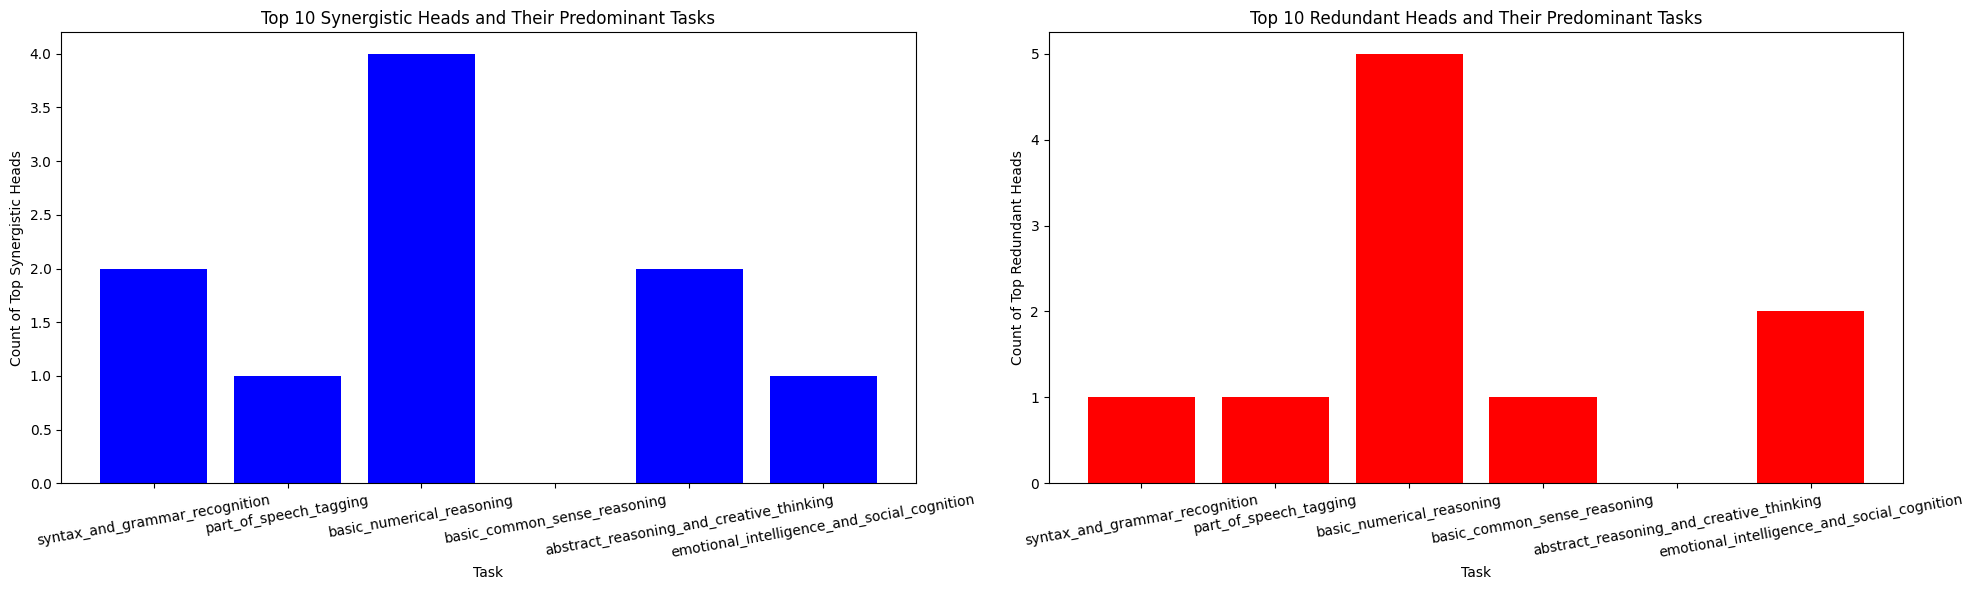

In [17]:
plot_most_syn_red_tasks(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], top_n=10)

### Average Rank of Most Significantly Activated Heads by Category

In [18]:
plot_rank_most_activated_heads_per_task(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], top_ns=[1,3,5,10,30, 50], save=True)

### Average Head Activation per Task

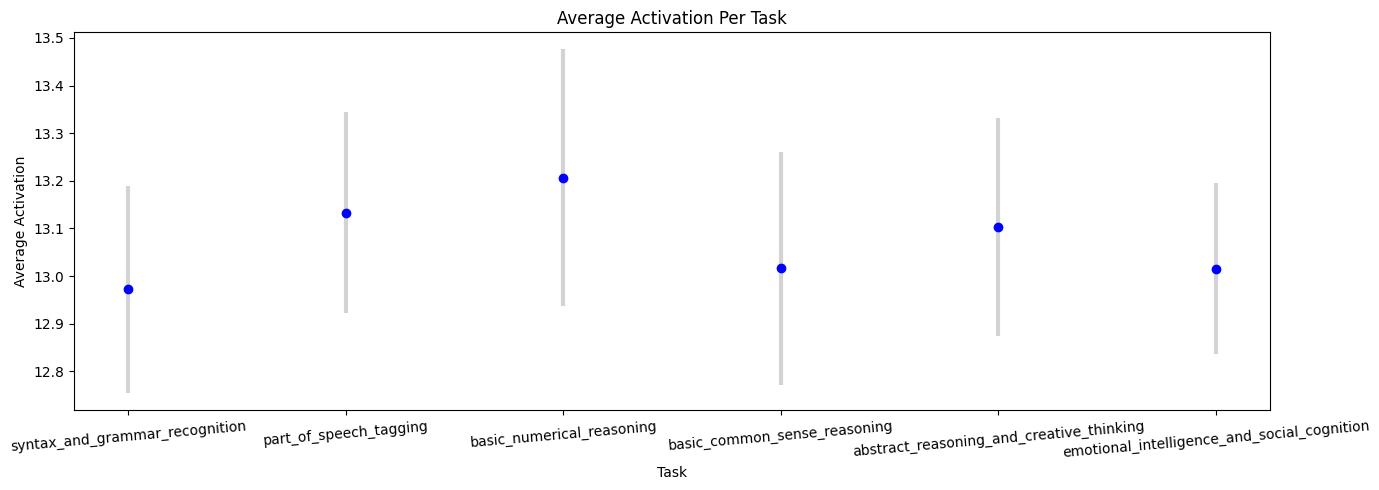

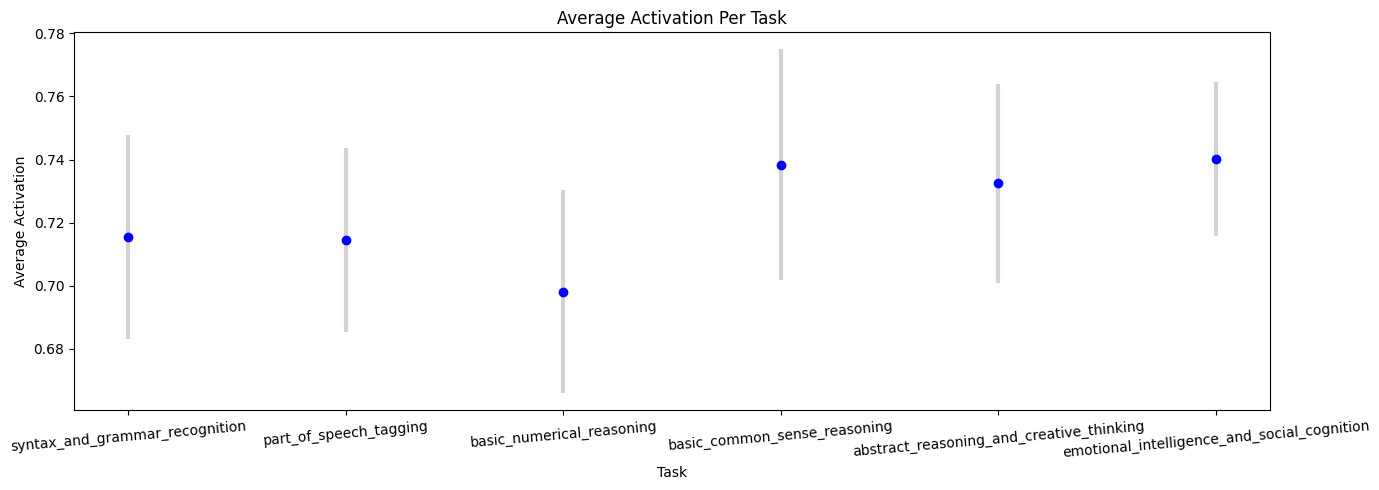

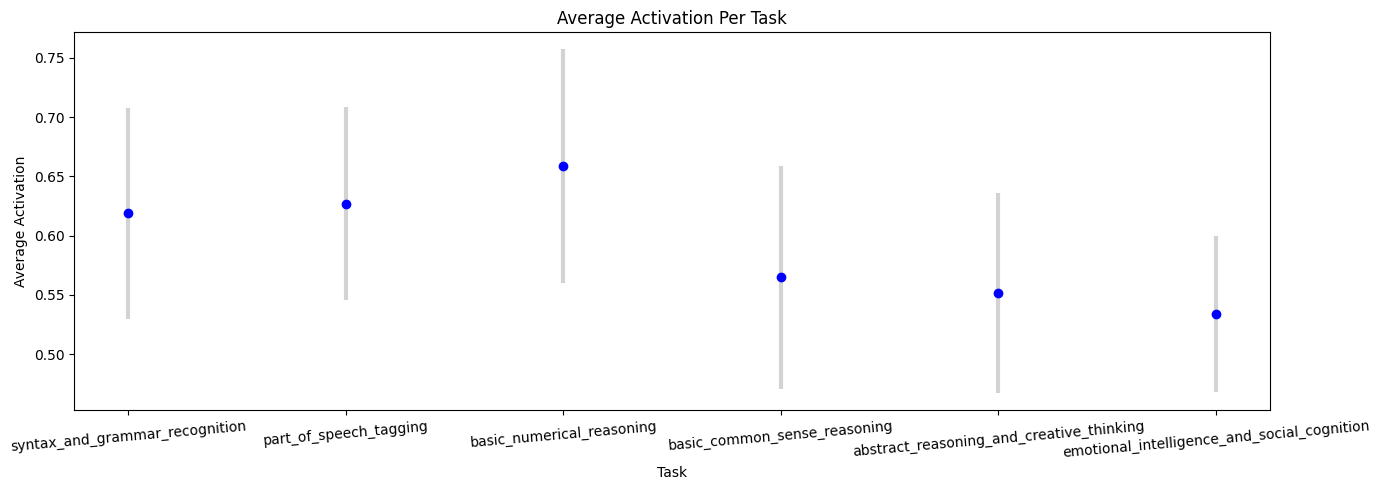

In [19]:
plot_average_head_activation_per_task(summary_stats_prompts)